In [1]:
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
from WSMBSS import *
os.chdir("..")
os.chdir("NumericalExperiments/SoundSeparation")
from scipy.io import wavfile

import numpy as np

import time
import pylab as pl
import string

import scipy
from scipy import signal
from scipy.io import wavfile
from scipy.stats import norm, kurtosis
from scipy.stats import ortho_group
#from FastICA import FastICA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
import warnings
warnings.filterwarnings("ignore")

In [2]:
sounds = []
corresponding_sound_name = []
for name in os.listdir("./sounds"):
    if name.split(".")[-1] == "wav":
        corresponding_sound_name.append(name)
        soundarray = wavfile.read(os.path.join("./sounds", name))[-1]
        soundarray = soundarray.astype('float32')
        soundarray /= soundarray.max()
        sounds.append(soundarray)
        
min_length = min( [len(x) for x in sounds])
sound_np = np.zeros((len(sounds), min_length))
for j in range(len(sounds)):
    sound_np[j,:] = sounds[j][:min_length] 

In [3]:
k = ((np.corrcoef(sound_np) - np.eye(len(sounds))))
most_correlations = np.unique(np.partition(k.flatten(), -6)[-6:])
for m in most_correlations:
    print(m)
    print( np.where(k == m))

0.1964667445977401
(array([10]), array([58]))
0.19646674459774013
(array([58]), array([10]))
0.1967219101568552
(array([ 0, 63]), array([63,  0]))
0.21147797467371807
(array([54, 63]), array([63, 54]))


In [4]:
k[10, 58], k[0, 63], k[54, 63]

(0.1964667445977401, 0.1967219101568552, 0.21147797467371807)

In [14]:
sounds = []
correlated_sound_names = [corresponding_sound_name[i] for i in [0, 54, 63]]
for name in correlated_sound_names:
    if name.split(".")[-1] == "wav":
        corresponding_sound_name.append(name)
        soundarray = wavfile.read(os.path.join("./sounds", name))[-1]
        soundarray = soundarray.astype('float32')
#         soundarray /= soundarray.max()
        soundarray = 2*ZeroOneNormalizeData(soundarray) - 1
        sounds.append(soundarray)
        
min_length = min( [len(x) for x in sounds])
sound_np = np.zeros((len(sounds), min_length))
for j in range(len(sounds)):
    sound_np[j,:] = sounds[j][:min_length] 

In [4]:
np.corrcoef(sound_np[[0,1,2],:])

array([[ 1.        ,  0.01949413,  0.01528112],
       [ 0.01949413,  1.        , -0.00416561],
       [ 0.01528112, -0.00416561,  1.        ]])

In [5]:
sound_np.shape

(67, 32030)

[62 59 14]
The following is the mixture matrix


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.993154276076787


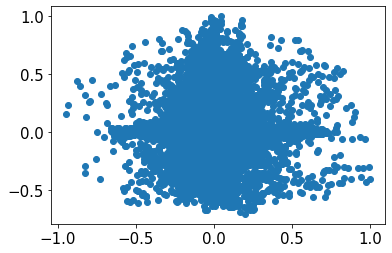

In [17]:
elements = np.random.choice(sound_np.shape[0], 3)
print(elements)
S = sound_np[elements,:]
S.min(), S.max()
NumberofMixtures = 3
NumberofSources = S.shape[0]
# INPUT_STD = 0.5
# A, X = WSM_Mixing_Scenario(S, NumberofMixtures, INPUT_STD)
A = ortho_group.rvs(NumberofMixtures)
X = A @ S

SNR=30

X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

plt.scatter(S[0,:], S[2,:])
plt.show()

In [18]:
# MUS = 0.35
# OUTPUT_COMP_TOL = 1e-5
# MAX_OUT_ITERATIONS= 3000
# LayerGains = [1,1]
# LayerMinimumGains = [1,1]
# LayerMaximumGains = [1e6,1.001]
# WScalings = [0.0033,0.0033]
# GamScalings = [0.01,0.01]
# zeta = 1e-4
# beta = 0.5
# muD = [25, 1e-2]

# s_dim = S.shape[0]
# x_dim = X.shape[0]
# h_dim = s_dim
# samples = S.shape[1]
# W_HX = np.eye(h_dim, x_dim)
# W_YH = np.eye(s_dim, h_dim)

NumberofSources = S.shape[0]
NumberofMixtures = X.shape[0]
MUS = 0.9
OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS= 3000
LayerActivationArguments = [0,1]
LayerGains = [4,1]
LayerMinimumGains = [1e-2,0.2]
LayerMaximumGains = [1e6,2.2]
WScalings = [0.0033,0.0033]
GamScalings = [0.02,0.02]
zeta = 1e-5
beta = 0.5
muD = [0.01, 1e-3]
s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = 2
samples = S.shape[1]

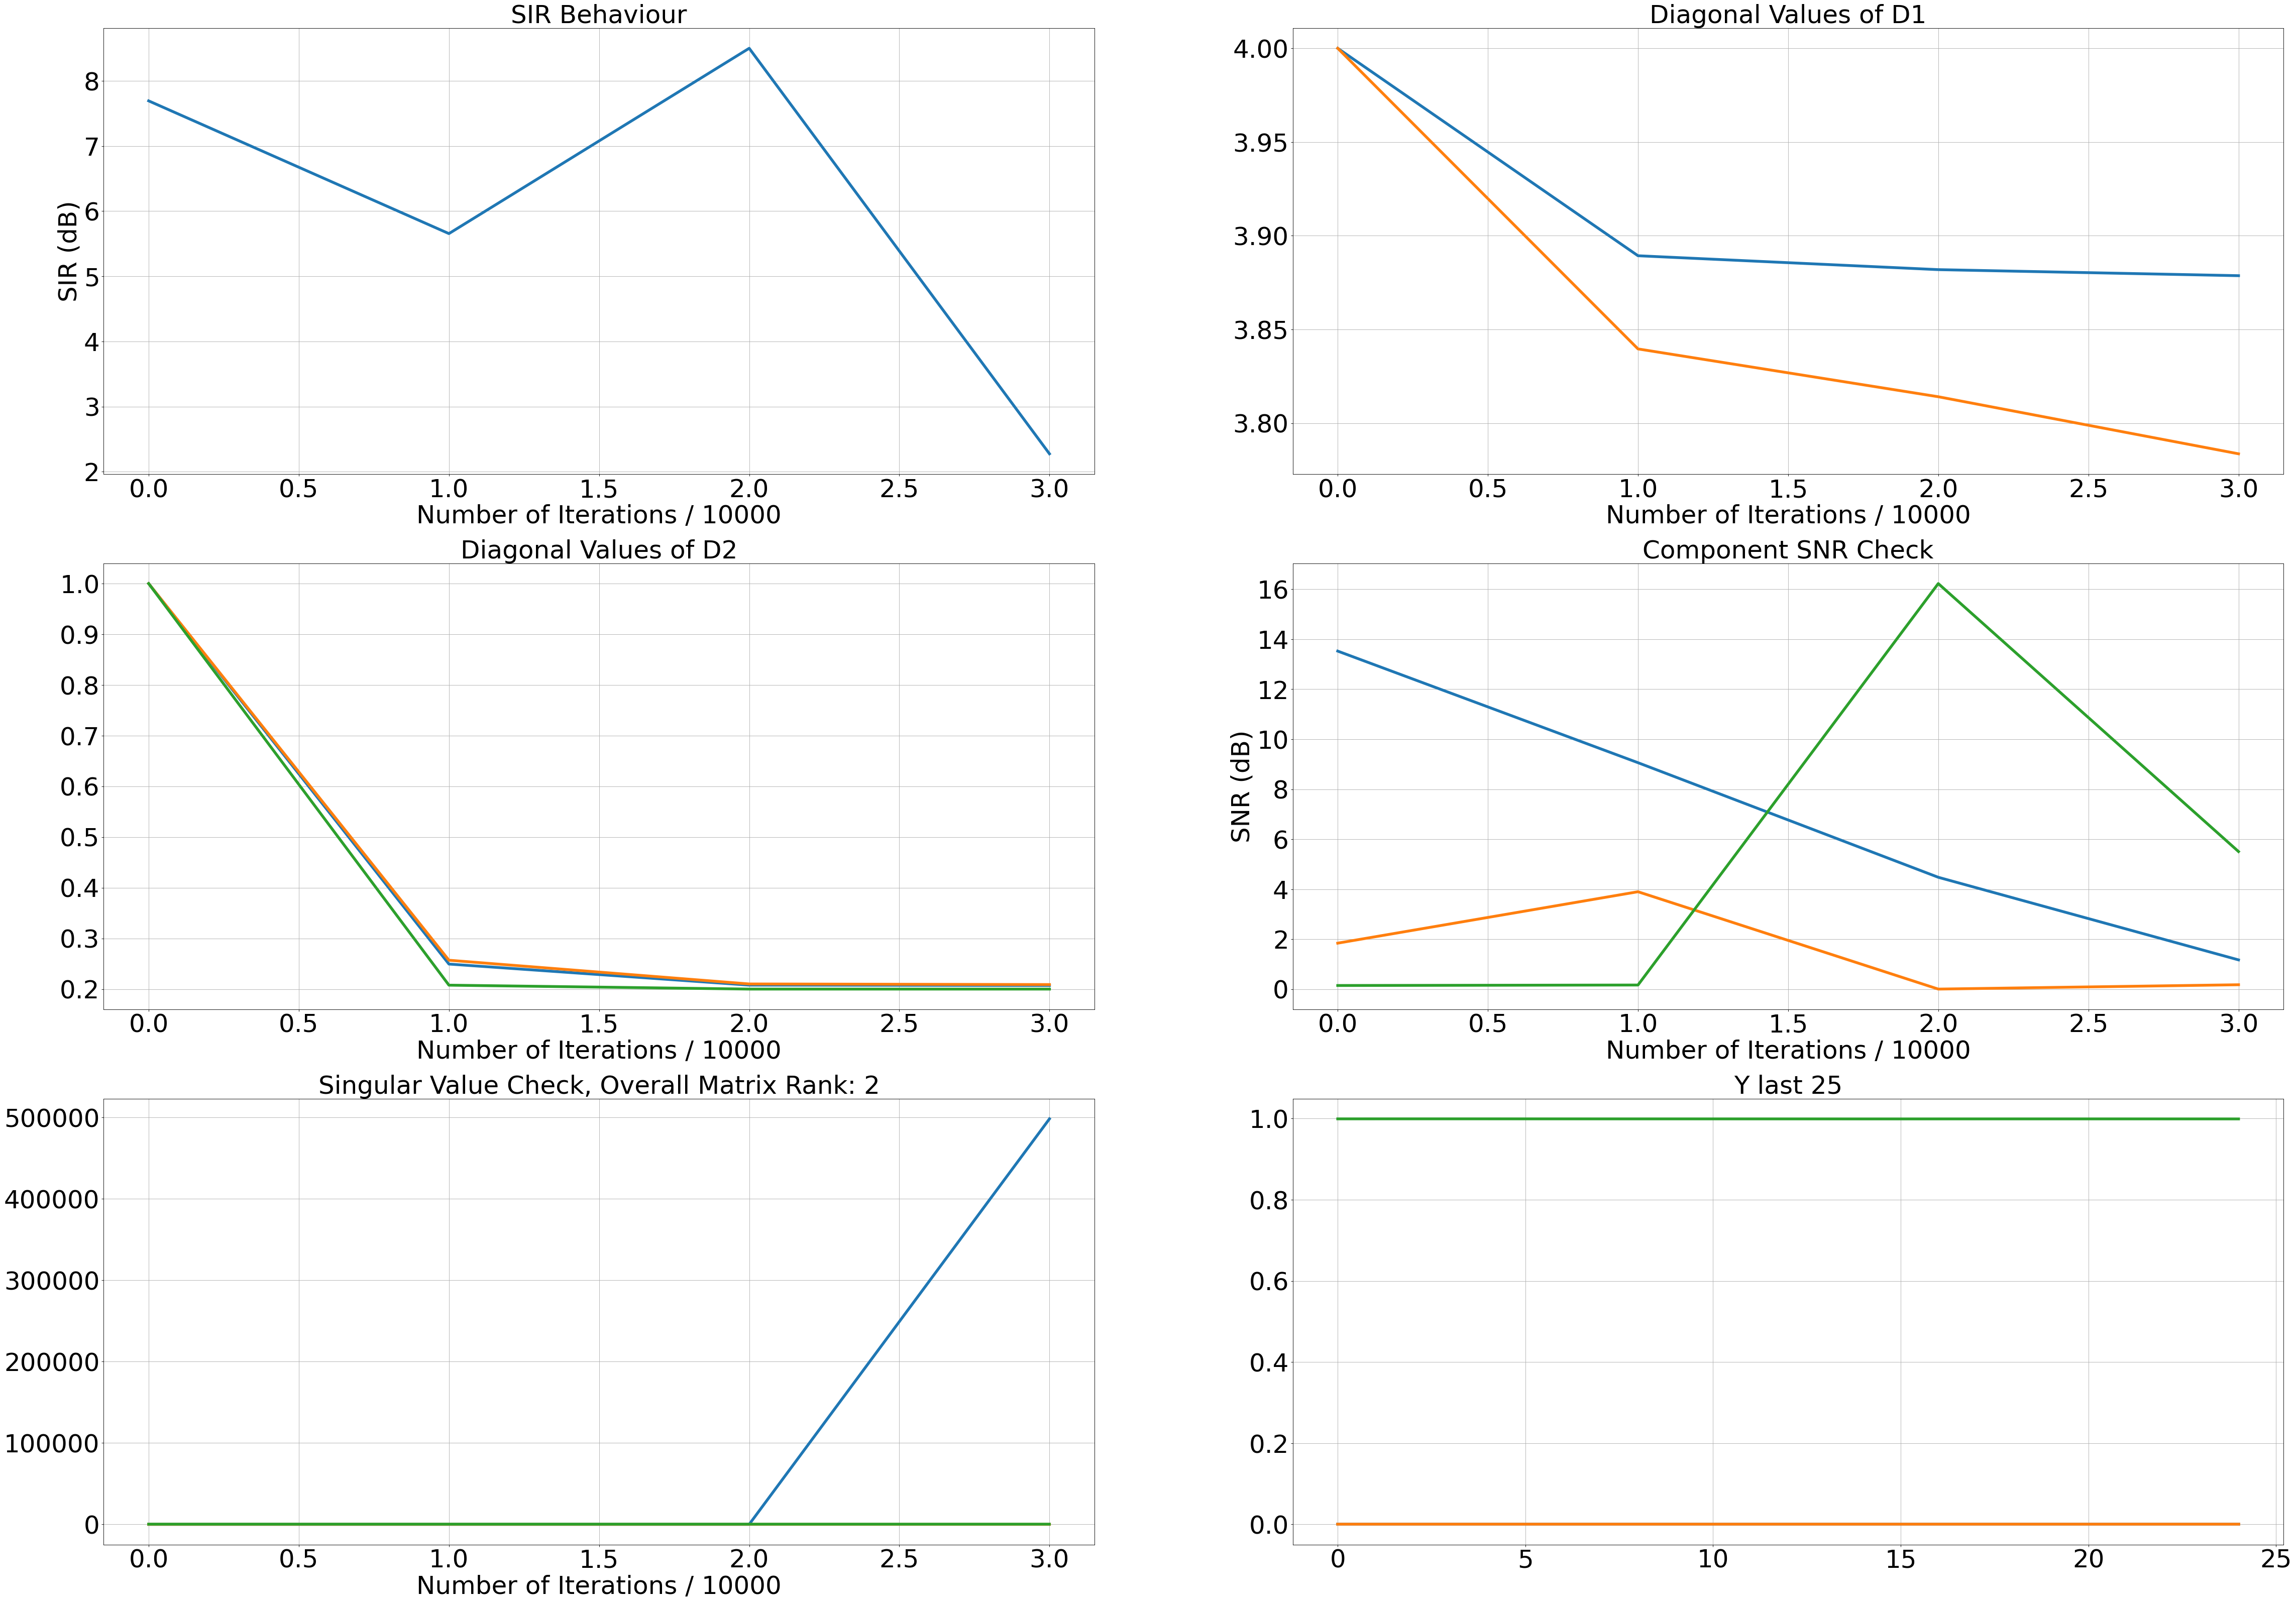

100%|██████████| 32030/32030 [03:38<00:00, 146.50it/s]


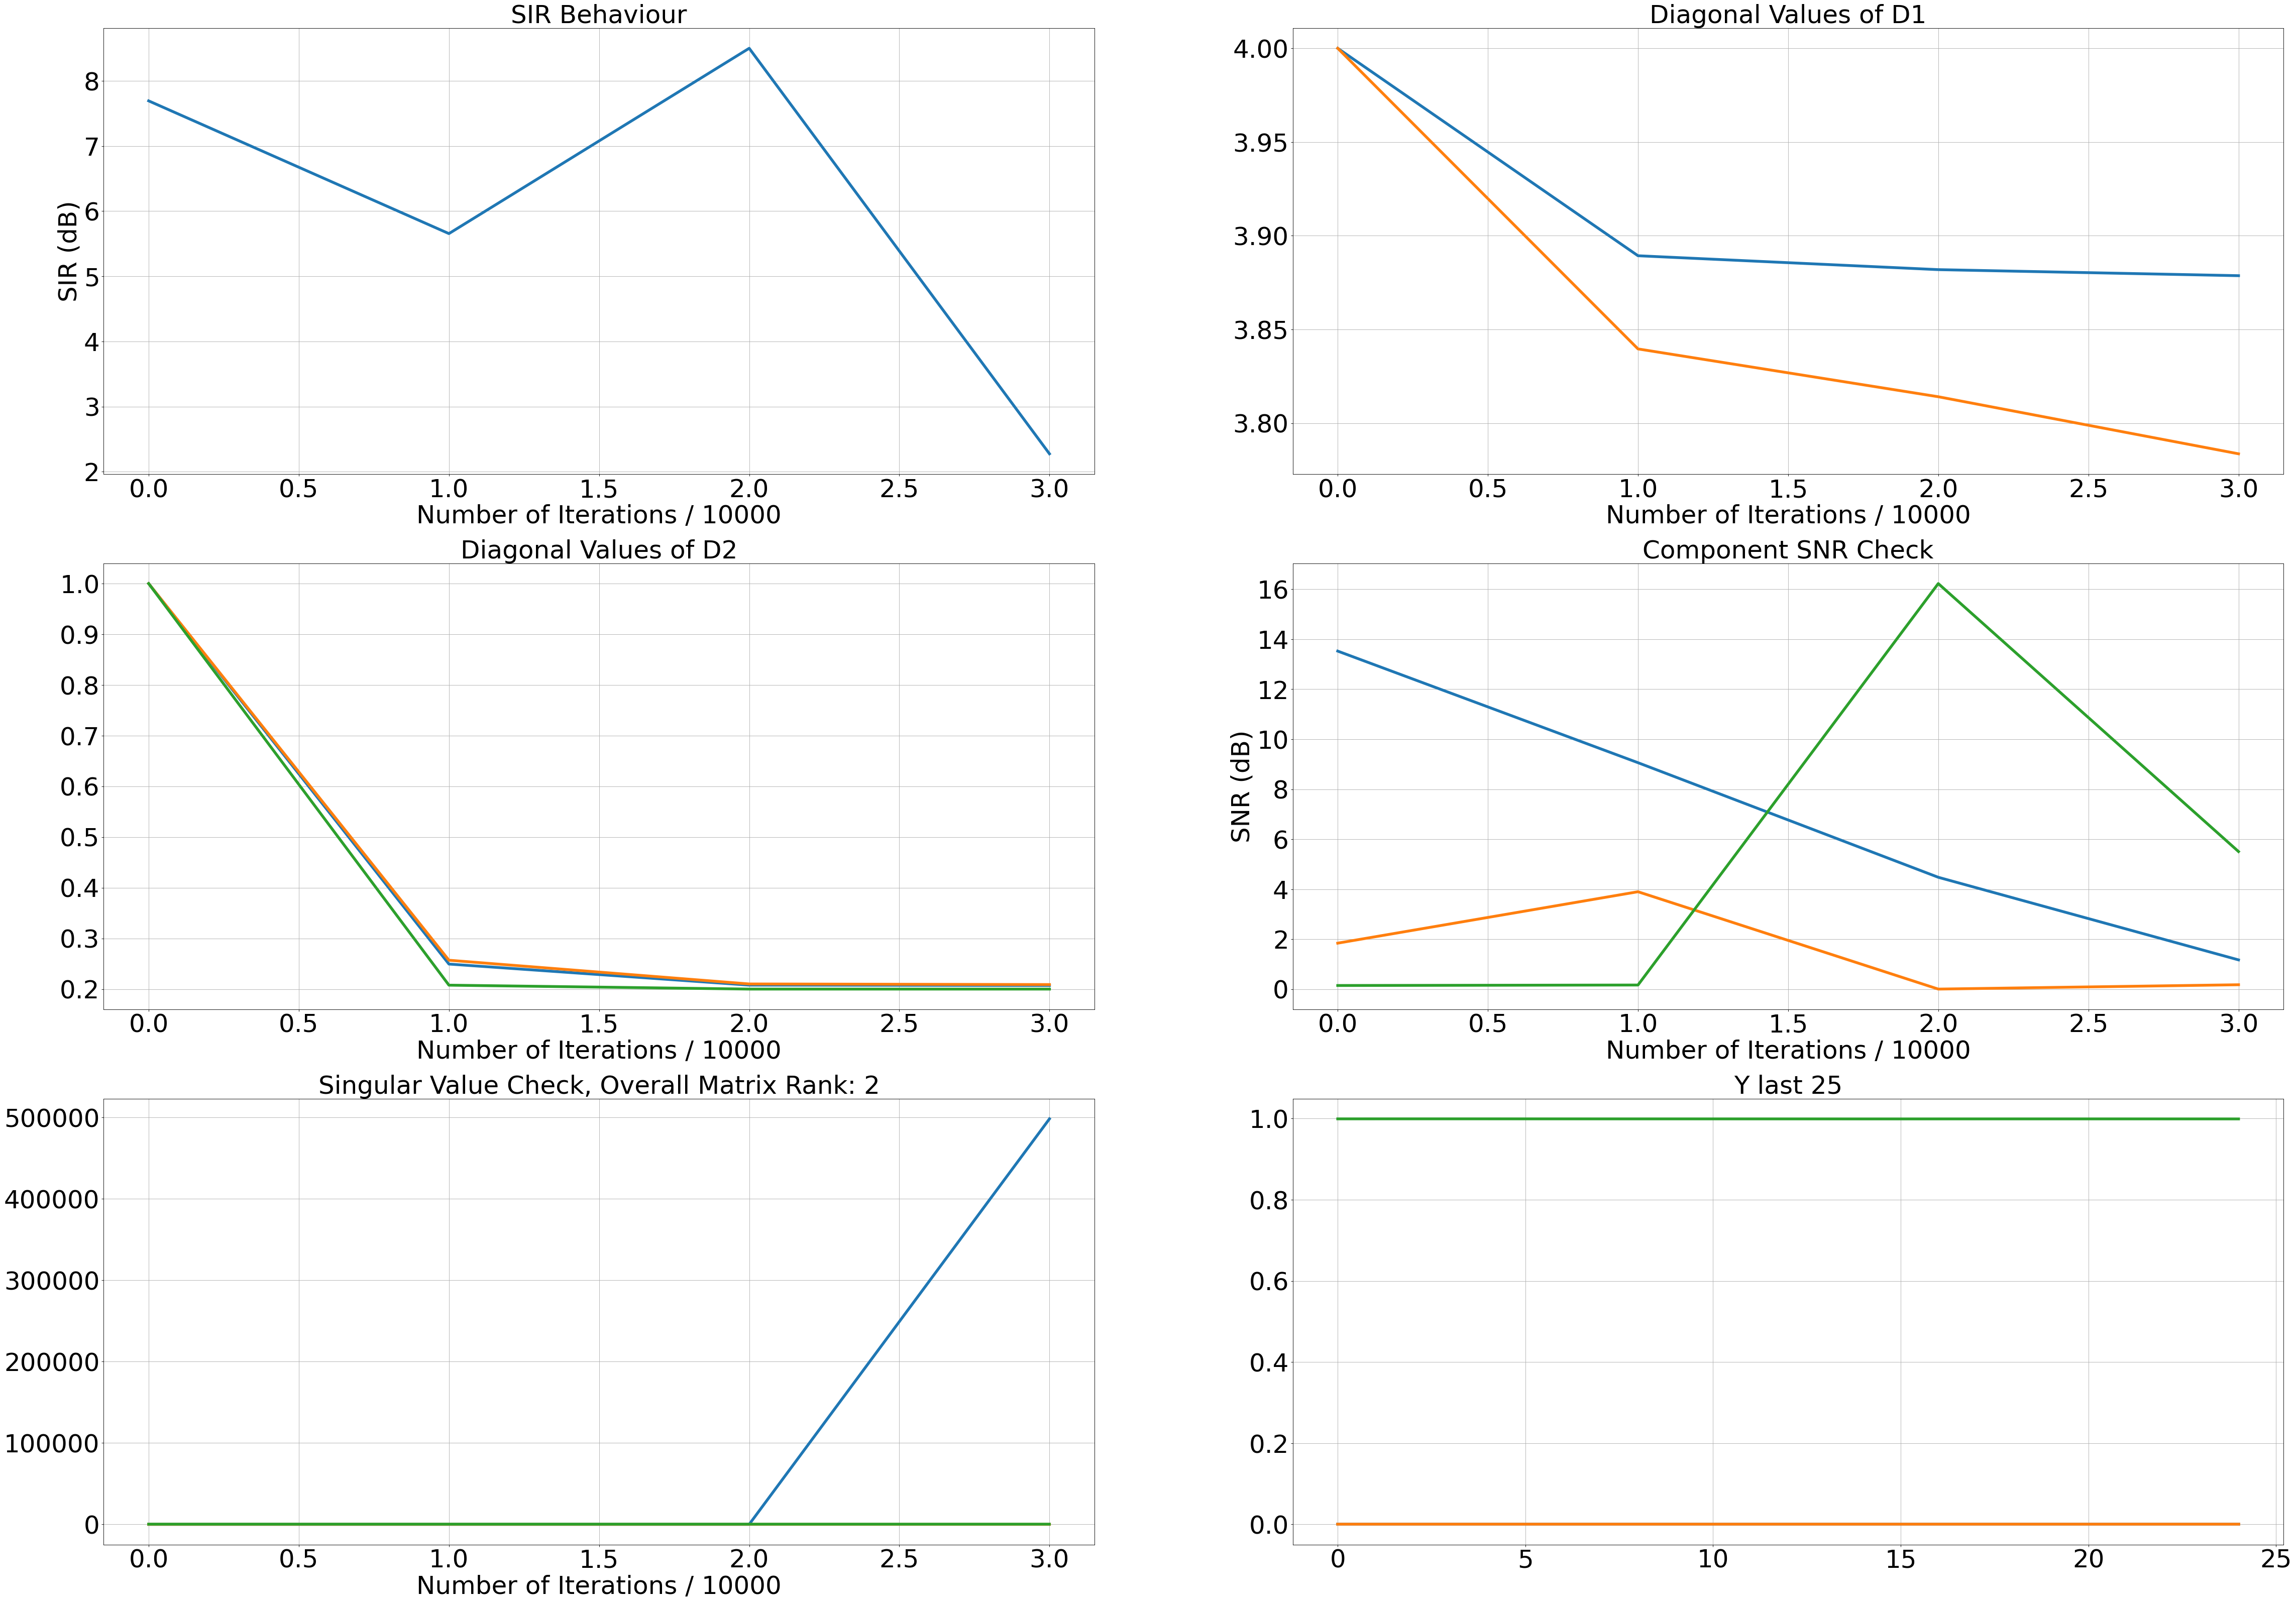

In [19]:
debug_iteration_point = 2000

model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                     gamma_start = MUS, beta = beta, zeta = zeta, 
                     muD = muD,WScalings = WScalings,
#                      W_HX = W_HX, W_YH = W_YH,
                     DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                     LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                     set_ground_truth = True, S = S, A = A)

model.fit_batch_simplex(X, n_epochs = 1, neural_lr_start = 0.01, shuffle = False,
                       debug_iteration_point = debug_iteration_point, 
                       plot_in_jupyter = True)

In [11]:
rate, a = wavfile.read('./sounds/MA02_04.wav')
rate, b = wavfile.read('./sounds/FA01_03.wav')
rate, c = wavfile.read('./sounds/FJ55_04.wav')
rate, d = wavfile.read('./sounds/MH43_08.wav')
rate, e = wavfile.read('./sounds/MH43_09.wav')

a = a.astype('float32')
b = b.astype('float32')
c = c.astype('float32')
d = d.astype('float32')
e = e.astype('float32')

a_max = np.max(a)
b_max = np.max(b)
c_max = np.max(c)
d_max = np.max(d)
e_max = np.max(e)

a /= a_max
b /= b_max
c /= c_max
d /= d_max
e /= e_max

shortest = min(len(a), len(b), len(c), len(d), len(e))
a = a[:shortest]
b = b[:shortest]
c = c[:shortest]
d = d[:shortest]
e = e[:shortest]

np.random.seed(101)
noise = np.random.uniform(-1, 1, len(a))
sources = np.stack((a, b, c, d, e, noise))

In [12]:
display_matrix(np.corrcoef(sources))

<IPython.core.display.Math object>